# 04 - MODELO RANDOM FOREST

Modelo de ensamble basado en árboles de decisión para clasificación binaria de fraude.
Incluye búsqueda de hiperparámetros, validación cruzada y evaluación completa.

## Librerías

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,
    balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Cargar Datos Preprocesados

In [21]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"\nFraude en train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"Fraude en test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.2f}%)")

X_train: (16000, 13)
X_test: (4000, 13)
y_train: (16000,)
y_test: (4000,)

Fraude en train: 160 (1.00%)
Fraude en test: 40 (1.00%)


## Balanceo de Clases con SMOTE


In [22]:
print("Distribución en Train antes de SMOTE:")
print(y_train.value_counts())

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar resample solo al conjunto de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribución en Train después de SMOTE:")
print(y_train_balanced.value_counts())

# Reemplazar las variables de entrenamiento
X_train = X_train_balanced
y_train = y_train_balanced

Distribución en Train antes de SMOTE:
isFraud
0    15840
1      160
Name: count, dtype: int64

Distribución en Train después de SMOTE:
isFraud
0    15840
1    15840
Name: count, dtype: int64


## Configuración Experimental - Malla de Hiperparámetros

In [23]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

print("Malla de Hiperparámetros para Random Forest:")
print(f"n_estimators: {param_grid['n_estimators']}")
print(f"max_depth: {param_grid['max_depth']}")
print(f"min_samples_split: {param_grid['min_samples_split']}")
print(f"min_samples_leaf: {param_grid['min_samples_leaf']}")
print(f"criterion: {param_grid['criterion']}")
print(f"\nTotal de combinaciones: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['criterion'])}")

Malla de Hiperparámetros para Random Forest:
n_estimators: [50, 100, 200, 300]
max_depth: [5, 10, 15, 20, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
criterion: ['gini', 'entropy']

Total de combinaciones: 360


## Metodología de Validación

In [24]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'balanced_accuracy': 'balanced_accuracy'
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV configurado con:")
print(f"- Validación cruzada: 5-fold estratificada")
print(f"- Métrica de selección: Balanced Accuracy")
print(f"- class_weight: balanced (para manejar desbalance)")
print(f"- Otras métricas evaluadas: {list(scoring.keys())}")

GridSearchCV configurado con:
- Validación cruzada: 5-fold estratificada
- Métrica de selección: Balanced Accuracy
- class_weight: balanced (para manejar desbalance)
- Otras métricas evaluadas: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'balanced_accuracy']


## Búsqueda de Hiperparámetros

In [25]:
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Balanced Accuracy (CV): {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Mejores parámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mejor Balanced Accuracy (CV): 0.9988


## Resultados de Validación Cruzada

In [26]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_balanced_accuracy')

top_10 = cv_results[[
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_criterion',
    'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
    'mean_test_f1', 'mean_test_recall', 'mean_test_precision'
]].head(10)

print("\nmejores configuraciones (validación cruzada):")
print(top_10.to_string())


mejores configuraciones (validación cruzada):
     param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf param_criterion  mean_test_balanced_accuracy  std_test_balanced_accuracy  mean_test_f1  mean_test_recall  mean_test_precision
148                  50            None                        5                       1            gini                     0.998769                    0.000483      0.998771          1.000000             0.997545
155                 300            None                       10                       1            gini                     0.998737                    0.000435      0.998739          0.999937             0.997545
145                 100            None                        2                       1            gini                     0.998706                    0.000365      0.998708          0.999937             0.997482
154                 200            None                       10                       1     

## Evaluación en Entrenamiento, Validación y Test del mejor modelo

In [27]:
best_model = grid_search.best_estimator_

# Predicciones en Train
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predicciones en Test
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Predicciones con validación cruzada (para intervalo de confianza)
y_val_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
y_val_pred_proba = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

## Cálculo de Métricas con Intervalos de Confianza

In [28]:
def compute_metrics_with_ci(y_true, y_pred, y_proba, set_name=''):
    metrics = {}

    # Balanced Accuracy
    ba = balanced_accuracy_score(y_true, y_pred)

    # Precision
    prec = precision_score(y_true, y_pred, zero_division=0)

    # Recall
    rec = recall_score(y_true, y_pred, zero_division=0)

    # F1-Score
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_proba)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Intervalo de confianza (95%) usando bootstrap
    n_bootstrap = 1000
    ba_bootstrap = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        ba_bootstrap.append(balanced_accuracy_score(y_true.iloc[idx], y_pred[idx]))

    ba_ci = np.percentile(ba_bootstrap, [2.5, 97.5])

    return {
        'Balanced Accuracy': f"{ba:.4f} [{ba_ci[0]:.4f}, {ba_ci[1]:.4f}]",
        'Precision': f"{prec:.4f}",
        'Recall': f"{rec:.4f}",
        'F1-Score': f"{f1:.4f}",
        'AUC-ROC': f"{auc_roc:.4f}",
        'Accuracy': f"{acc:.4f}"
    }

metrics_train = compute_metrics_with_ci(y_train, y_train_pred, y_train_pred_proba, 'Train')
metrics_val = compute_metrics_with_ci(y_train, y_val_pred, y_val_pred_proba, 'Validación')
metrics_test = compute_metrics_with_ci(y_test, y_test_pred, y_test_pred_proba, 'Test')

results_df = pd.DataFrame({
    'Train': metrics_train,
    'Validación (CV)': metrics_val,
    'Test': metrics_test
})

print("\nRESULTADOS DEL MODELO RANDOM FOREST")
print(results_df.to_string())


RESULTADOS DEL MODELO RANDOM FOREST
                                     Train          Validación (CV)                     Test
Balanced Accuracy  1.0000 [1.0000, 1.0000]  0.9988 [0.9984, 0.9991]  0.9239 [0.8600, 0.9754]
Precision                           1.0000                   0.9975                   0.7907
Recall                              1.0000                   1.0000                   0.8500
F1-Score                            1.0000                   0.9988                   0.8193
AUC-ROC                             1.0000                   1.0000                   0.9703
Accuracy                            1.0000                   0.9988                   0.9962


## Matriz de Confusión

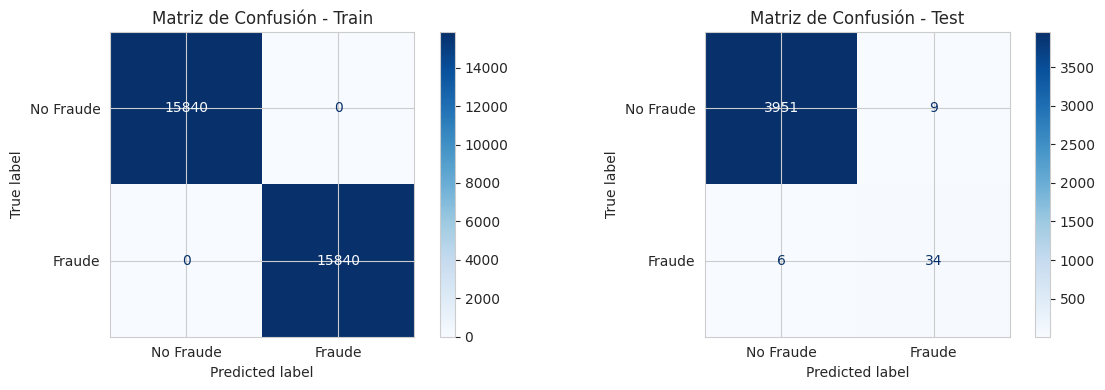

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=['No Fraude', 'Fraude']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Matriz de Confusión - Train')

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=['No Fraude', 'Fraude']).plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Matriz de Confusión - Test')

plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Curva ROC

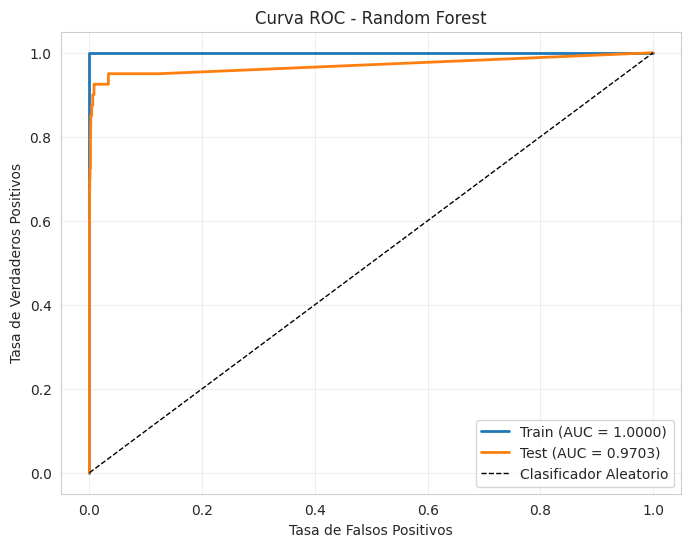

In [30]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('rf_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## Importancia de Características

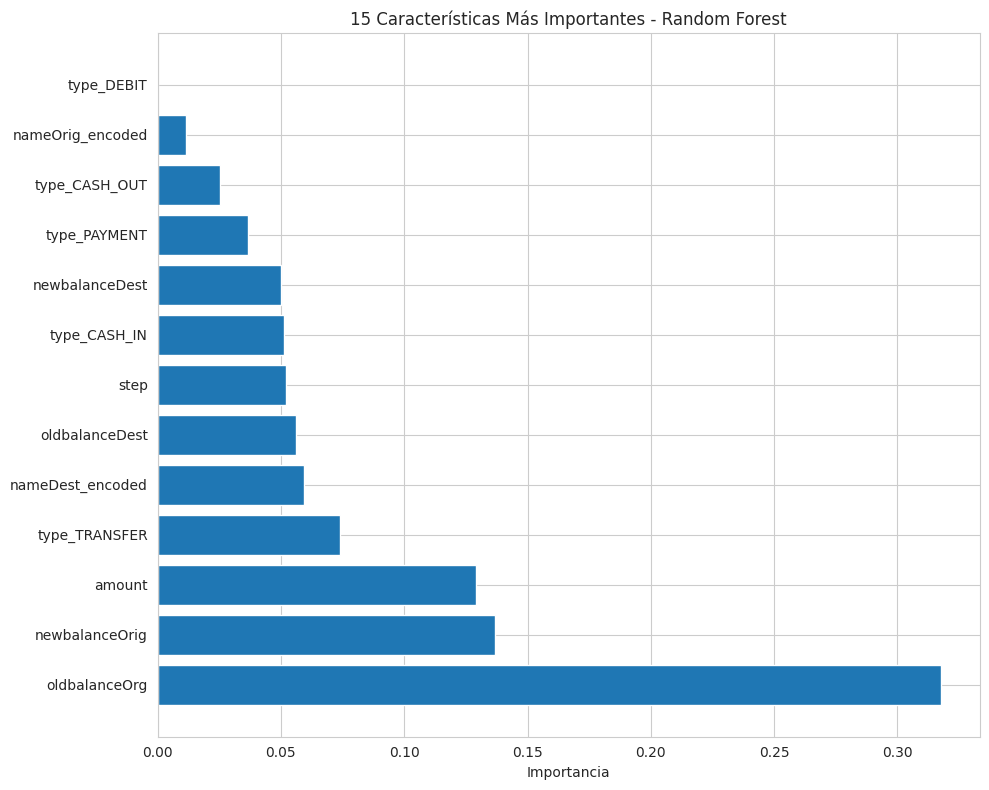


 10 Características más importantes:
             feature  importance
2      oldbalanceOrg    0.317573
3     newbalanceOrig    0.136916
1             amount    0.129127
10     type_TRANSFER    0.074056
12  nameDest_encoded    0.059506
4     oldbalanceDest    0.056249
0               step    0.052217
6       type_CASH_IN    0.051351
5     newbalanceDest    0.049913
9       type_PAYMENT    0.036553


In [31]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importancia')
plt.title('15 Características Más Importantes - Random Forest')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n 10 Características más importantes:")
print(feature_importance.head(10).to_string())

## Efecto de Hiperparámetros

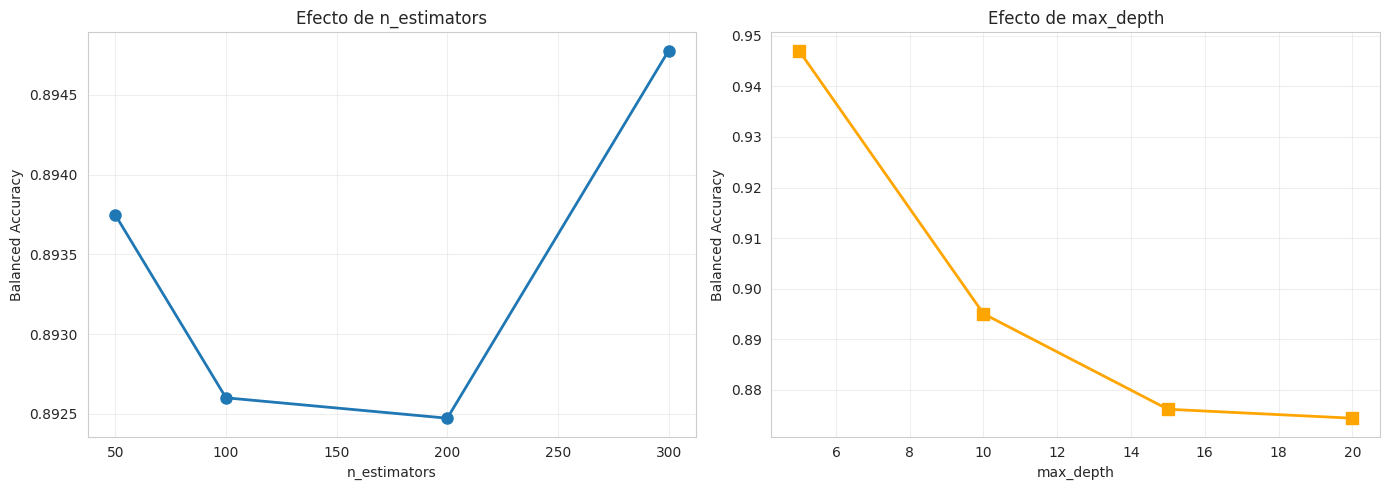

In [ ]:
# Análisis del efecto de n_estimators y max_depth
cv_results_sorted = cv_results.sort_values('param_n_estimators')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Efecto de n_estimators
n_est_vals = cv_results_sorted['param_n_estimators'].unique()
means_ba = [cv_results_sorted[cv_results_sorted['param_n_estimators'] == n]['mean_test_balanced_accuracy'].mean()
            for n in n_est_vals]

axes[0].plot(n_est_vals, means_ba, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_title('Efecto de n_estimators')
axes[0].grid(alpha=0.3)

# Efecto de max_depth
cv_results_sorted_depth = cv_results.sort_values('param_max_depth')
depth_vals = cv_results_sorted_depth['param_max_depth'].unique()
means_depth = [cv_results_sorted_depth[cv_results_sorted_depth['param_max_depth'] == d]['mean_test_balanced_accuracy'].mean()
               for d in depth_vals]

axes[1].plot(depth_vals, means_depth, marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Balanced Accuracy')
axes[1].set_title('Efecto de max_depth')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rf_hyperparameter_effect.png', dpi=300, bbox_inches='tight')
plt.show()